In [12]:
import cv2
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import easyocr
from PIL import Image, ImageEnhance
import numpy as np

In [252]:
def preprocess_image(image_path):   

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Calculate the new dimensions
    new_height = int(height * 2)
    new_width = int(width * 2)

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))


    pil_image = Image.fromarray(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    
    enhancer = ImageEnhance.Contrast(pil_image)
    contrast_img = enhancer.enhance(1.5)

    enhancer = ImageEnhance.Brightness(contrast_img)
    bright_img = enhancer.enhance(1.2)

    sharper = ImageEnhance.Sharpness(bright_img)
    sharper_img = sharper.enhance(2)

    enhanced_image = cv2.cvtColor(np.array(sharper_img), cv2.COLOR_RGB2BGR)
    
    gray = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    blurred = cv2.GaussianBlur(binary, (5, 5), 0)


    unsharp_mask = cv2.addWeighted(gray, 2, blurred, -1, 0)
    
    return unsharp_mask


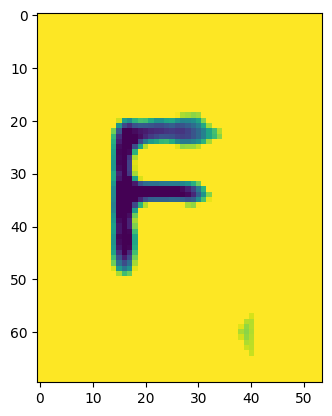

In [253]:

path = r'C:\Users\pc\Desktop\lp BigData\s6\cropped_3.jpg'

img = preprocess_image(path)
plt.imshow(img)

Using CPU. Note: This module is much faster with a GPU.


[[[[10, 16], [36, 16], [36, 50], [10, 50]], 'F']]


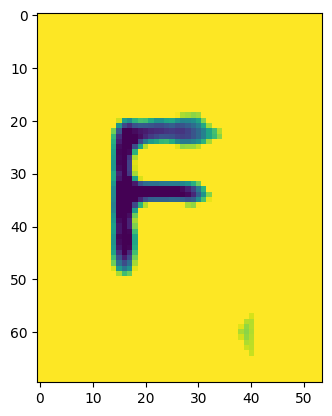

In [254]:

reader = easyocr.Reader(['fr'], gpu=False) 
res = reader.readtext(img, paragraph=True)

plt.imshow(img)
print(res)

In [255]:
import pytesseract

In [256]:

img = Image.open(path)
# img = preprocess_image(path)

text = pytesseract.image_to_string(img)
    
print(text)

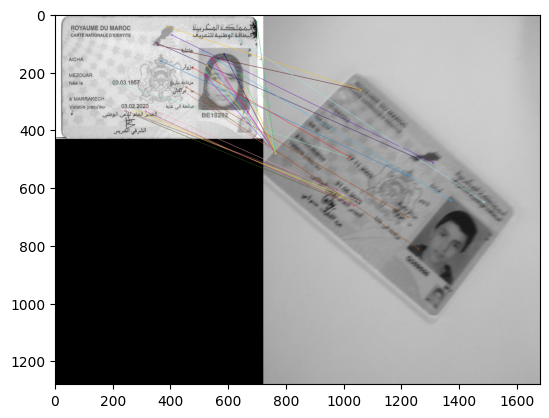

In [37]:
import cv2

# Load the images
image_original = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\moroccan_idCard_scanner\ids\old_card\id_1_3.jpg', cv2.IMREAD_GRAYSCALE)
image_rotated = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\test_crop\crop3.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_original, descriptors_original = sift.detectAndCompute(image_original, None)
keypoints_rotated, descriptors_rotated = sift.detectAndCompute(image_rotated, None)

# Match descriptors using FLANN (Fast Library for Approximate Nearest Neighbors)
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches = flann.knnMatch(descriptors_original, descriptors_rotated, k=2)

# Ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
image_matches = cv2.drawMatches(image_original, keypoints_original, image_rotated, keypoints_rotated, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(image_matches)

# Display the matches
# cv2.imshow('Matches', image_matches)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [76]:
import cv2
import numpy as np

# Load reference card images
old_front = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\old_front.jpg', cv2.IMREAD_GRAYSCALE)
old_back = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\old_back.jpg', cv2.IMREAD_GRAYSCALE)
new_front = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\new_front.jpg', cv2.IMREAD_GRAYSCALE)
new_back = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\new_back.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

def extract_features(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors


def match_features(descriptors1, descriptors2):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return len(good_matches)



def find_most_similar_card(input_card):
    scores = []
    keypoints_input, descriptors_input = extract_features(input_card)
    for ref_card in [old_front, old_back, new_front, new_back]:
        keypoints_ref, descriptors_ref = extract_features(ref_card)
        score = match_features(descriptors_input, descriptors_ref)
        scores.append(score)
    most_similar_card_type = np.argmax(scores) + 1  # Card types are numbered from 1 to 4
    return most_similar_card_type



def detect_rotation(image, ref_card):
    # Extract keypoints and descriptors
    keypoints_input, descriptors_input = extract_features(image)
    keypoints_ref, descriptors_ref = extract_features(ref_card)
    
    # Match features between input and reference card
    matches = match_features(descriptors_input, descriptors_ref)
    
    # Compute rotation angle
    rotation_angle = 0  # Default rotation angle if no match is found
    if matches > 10:  # Adjust this threshold based on your images
        src_pts = np.float32([keypoint.pt for keypoint in keypoints_input])
        dst_pts = np.float32([keypoint.pt for keypoint in keypoints_ref])
        
        # Check if both sets of points have the same number of points
        if src_pts.shape[0] == dst_pts.shape[0]:
            transformation_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
            rotation_angle_rad = -np.arctan2(transformation_matrix[0, 1], transformation_matrix[0, 0])
            rotation_angle = np.degrees(rotation_angle_rad)
            
            # Apply rotation to the input image
            height, width = image.shape
            rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), rotation_angle, 1)
            rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
            return rotated_image
    
    return image  # Return original image if no rotation is detected



# def rotate_image(image, angle):
#     # Get image dimensions
#     height, width = image.shape[:2]
    
#     print(angle)
#     # Calculate the rotation matrix
#     rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), -angle, 1)
    
#     # Apply the rotation to the image
#     rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
#     return rotated_image



def classify(input_card_image):
    most_similar_card_type= find_most_similar_card(input_card_image)

    if most_similar_card_type == 1:
        rotation_ref = old_front
    elif most_similar_card_type ==2:
        rotation_ref = old_back
    elif most_similar_card_type ==3:
        rotation_ref = new_front
    else :
        rotation_ref = new_back

    rotation_angle = detect_rotation(input_card_image, rotation_ref)


    return most_similar_card_type, rotation_angle




In [77]:
# Example usage
input_card_image = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\test_crop\crop2.jpg', cv2.IMREAD_GRAYSCALE)
most_similar_card_type, image_rotated= classify(input_card_image)

# image_rotated = rotate_image(input_card_image, rotation_angle)

print("Most similar card type:", most_similar_card_type)

Most similar card type: 1


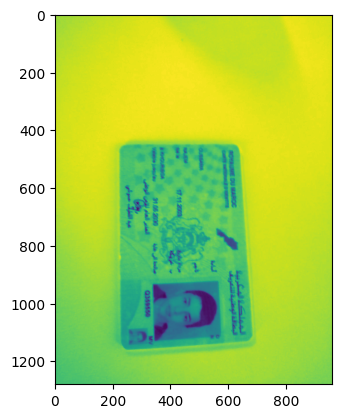

In [78]:
import matplotlib.pyplot as plt
plt.imshow(image_rotated)

In [ ]:
def detect_rotation(image, ref_card):
    # Extract keypoints and descriptors
    keypoints_input, descriptors_input = extract_features(image)
    keypoints_ref, descriptors_ref = extract_features(ref_card)
    
    # Match features between input and reference card
    matches = match_features(descriptors_input, descriptors_ref)
    
    # Compute rotation angle
    rotation_angle = 0  # Default rotation angle if no match is found
    if matches > 10:  # Adjust this threshold based on your images
        src_pts = np.float32([keypoint.pt for keypoint in keypoints_input])
        dst_pts = np.float32([keypoint.pt for keypoint in keypoints_ref])
        
        # Check if both sets of points have the same number of points
        if src_pts.shape[0] == dst_pts.shape[0]:
            transformation_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
            rotation_angle_rad = -np.arctan2(transformation_matrix[0, 1], transformation_matrix[0, 0])
            rotation_angle = np.degrees(rotation_angle_rad)
    
    return rotation_angle


def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [122]:
import cv2
import numpy as np

# Load reference card images
old_front = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\old_front.jpg', cv2.IMREAD_GRAYSCALE)
old_back = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\old_back.jpg', cv2.IMREAD_GRAYSCALE)
new_front = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\new_front.jpg', cv2.IMREAD_GRAYSCALE)
new_back = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\card_references\new_back.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

def extract_features(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return len(good_matches)

def find_most_similar_card(input_card):
    scores = []
    keypoints_input, descriptors_input = extract_features(input_card)
    for ref_card in [old_front, old_back, new_front, new_back]:
        keypoints_ref, descriptors_ref = extract_features(ref_card)
        score = match_features(descriptors_input, descriptors_ref)
        scores.append(score)
    most_similar_card_type = np.argmax(scores) + 1  # Card types are numbered from 1 to 4
    return most_similar_card_type

def detect_rotation(input_image, similar_image):


    # Detect ORB keypoints and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(input_image, None)
    kp2, des2 = orb.detectAndCompute(similar_image, None)

    # Match keypoints
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Estimate perspective transformation using MSAC
    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)

    # Check if transformation is valid
    if M is None:
        return None  # Transformation could not be estimated

    # Calculate rotation angle using matrix inverse
    rotation_matrix = np.linalg.inv(M[:, :2])
    rotation_angle = -np.degrees(np.arctan2(rotation_matrix[0, 1], rotation_matrix[0, 0]))

    return rotation_angle

def rotate_image(image, angle):
    # Get image dimensions
    height, width = image.shape[:2]
    
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), -angle, 1)
    
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    return rotated_image

def classify(input_card_image):
    most_similar_card_type = find_most_similar_card(input_card_image)

    if most_similar_card_type == 1:
        rotation_ref = old_front
    elif most_similar_card_type == 2:
        rotation_ref = old_back
    elif most_similar_card_type == 3:
        rotation_ref = new_front
    else:
        rotation_ref = new_back

    rotation_angle = detect_rotation(input_card_image, rotation_ref)

    return most_similar_card_type, rotation_angle

# Example usage
input_card_image = cv2.imread(r'C:\Users\pc\Desktop\lp BigData\s6\test_crop\crop2.jpg')
most_similar_card_type, rotation_angle = classify(input_card_image)

image_rotated = rotate_image(input_card_image, rotation_angle)

print("Most similar card type:", most_similar_card_type)


Most similar card type: 1


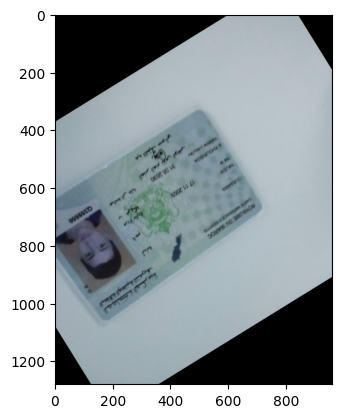

In [123]:
plt.imshow(image_rotated)